In [1]:
import os
import sys
import pickle
import random
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sys.path.append(f"{os.getcwd()}/../")

from processing.utils import CleanUp, SNOWBALL_STEMMER
from database.models import RawHashtagComments, UserLocation

sns.set(style="darkgrid")
%matplotlib inline

normalizar = CleanUp(remove_stopwords=True)

In [2]:
hashtags_ = pd.DataFrame(list(RawHashtagComments.select().dicts()))
hashtags_ = hashtags_.drop(["hash"], axis=1)
users_ = pd.DataFrame(list(UserLocation.select().dicts()))

In [3]:
print(f"Qtde. de Comentarios            : {len(hashtags_)}")
print(f"Qtde. de Comentarios positivos  : {len(hashtags_[hashtags_['classify'] == 'positivo'])}")
print(f"Qtde. de Comentarios negativos  : {len(hashtags_[hashtags_['classify'] == 'negativo'])}")
print("-" * 40)
print(f"Qtde. de Usuarios geolocalizados: {len(users_)}")
print(f"Qtde. de Usuarios em SP         : {len(users_[users_['state'] == 'SP'])}")

Qtde. de Comentarios            : 188090
Qtde. de Comentarios positivos  : 85647
Qtde. de Comentarios negativos  : 102443
----------------------------------------
Qtde. de Usuarios geolocalizados: 42963
Qtde. de Usuarios em SP         : 8431


Exemplos de comentarios com suas classificacoes:

In [4]:
for idx, row in hashtags_.sample(n=5).iterrows():
    print(f"- {row.classify} => {row.comment}")

- positivo => acho que peguei corona vírus, perdi o apetite de faxinar a casa
- positivo => Valeu corona, mais um dia que estou indo de encontro com a solidão 0:21 44,8 mil visualizações 49 1,4 mil 3,5 mil
- negativo => Eu não sei vcs mas eu tenho a impressão de que já peguei Covid e me curei viu
- negativo => Lembrando que eu tô bem gente, não estou com vírus ativo e não tô contagiando ninguém. Citar Tweet O corona me pegou, tentei escapar não consegui.  · 1 h Alô fioCruz, achamos a cura pro corona.
- negativo => Pqp me deu falta de ar e um alívio muito grande! Citar Tweet daisies @g4yminist  · 13 de mai velho, eu to me tremendo todinho com este vídeo, eu vi ele com uma agonia no peito.


In [5]:
wordcloud = WordCloud(
    width=640, height=480,
    background_color="white"
).generate(" ".join(hashtags_["sanitized_comment"].tolist()))

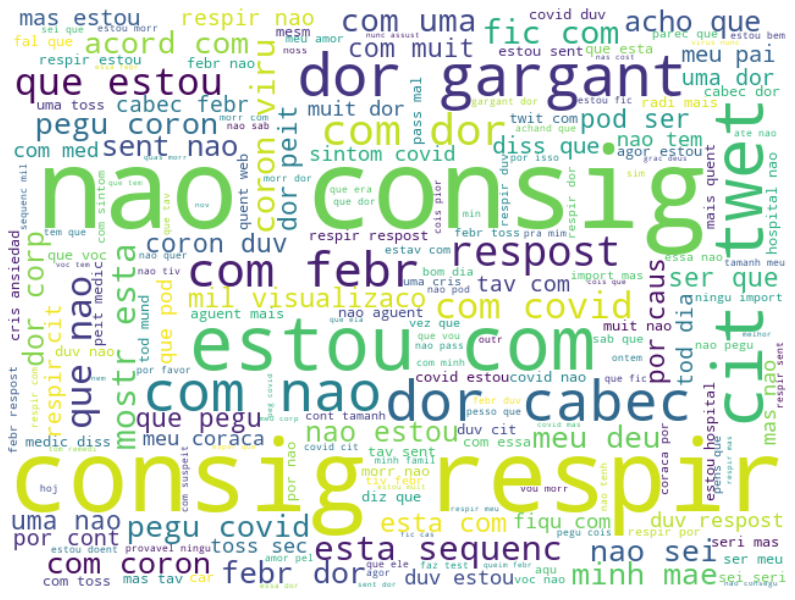

In [6]:
plt.figure(figsize=(14, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [7]:
# Pega todos os usuarios do estado de sao paulo
# sp = users_[users_['state'] == 'SP'].copy()
# Sem filtrar por estado...
sp = users_.copy()
sp['count'] = 1
# filtra estes usuarios com comentarios identificados como positivo
nsp = hashtags_[(hashtags_['username'].isin(sp['username'])) & (hashtags_['classify'] == 'positivo')]['username']
# Tendo os usuarios com comentarios positivos filtra novamente
sp = sp[sp['username'].isin(nsp)]
# Agrupa e soma a quantidade por cidade do estado de sao paulo
sp = sp.groupby(['city']).sum().reset_index()[['city', 'count']].sort_values(by=['count'], ascending=False)

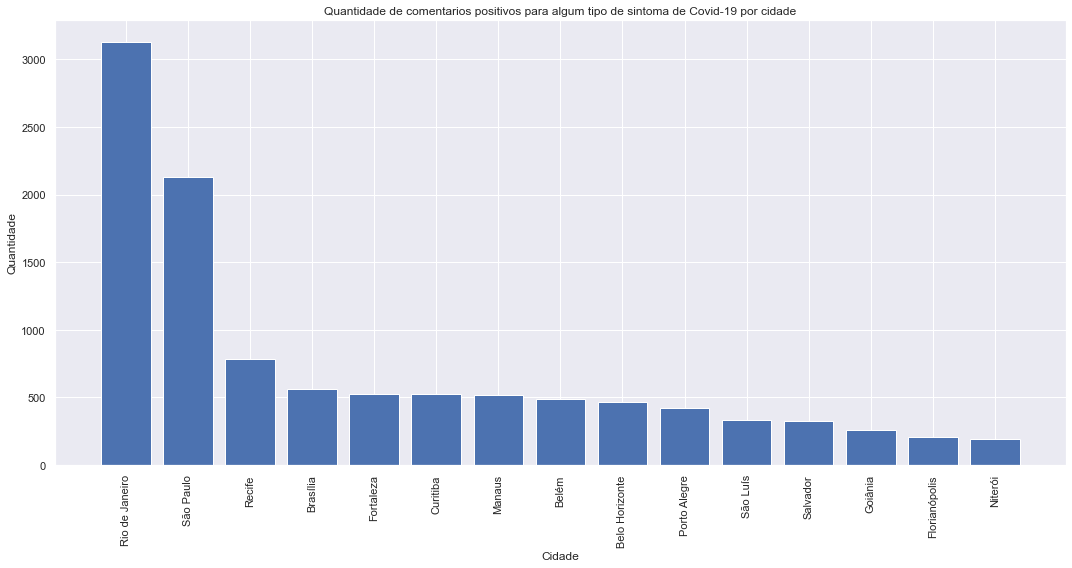

In [8]:
# Grafico
plt.figure(figsize=(15, 8))
plt.title("Quantidade de comentarios positivos para algum tipo de sintoma de Covid-19 por cidade")
plt.bar(sp['city'][:15], sp['count'][:15])
plt.xticks(rotation=90)
plt.xlabel("Cidade")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

In [9]:
df_dt = hashtags_[hashtags_['classify'] == 'positivo'].copy()
df_dt['date'] = df_dt['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_dt['count'] = 1
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 1, 1)]

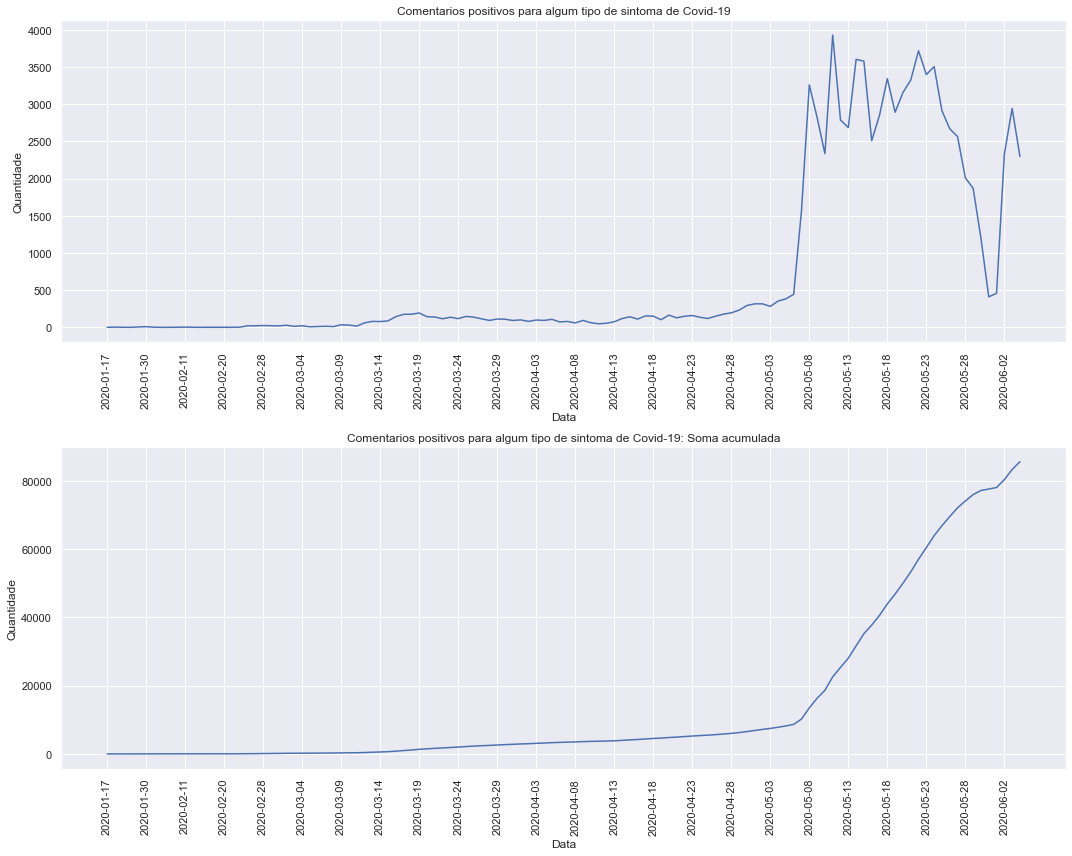

In [10]:
datas = df_dt['date'].to_numpy()
tempo = np.arange(1, len(datas) + 1)
cnt = df_dt['count']
cumsum = np.cumsum(cnt)

steps = 5
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.title("Comentarios positivos para algum tipo de sintoma de Covid-19")
plt.plot(tempo, cnt)
plt.xticks(np.arange(1, len(datas), steps), datas[::steps], rotation=90)
plt.xlabel("Data")
plt.ylabel("Quantidade")
plt.subplot(2, 1, 2)
plt.title("Comentarios positivos para algum tipo de sintoma de Covid-19: Soma acumulada")
plt.plot(tempo, cumsum)
plt.xticks(np.arange(1, len(datas), steps), datas[::steps], rotation=90)
plt.xlabel("Data")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()